In [0]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.appName('House').getOrCreate()
df=spark.read.csv("/content/sample_data/california_housing_train.csv",inferSchema=True,header=True)


In [0]:
df.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
only showing top 3 rows



In [0]:
#To display rows in pandas style
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


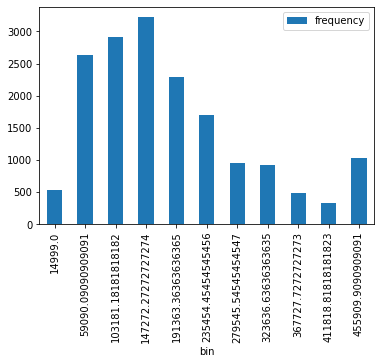

In [0]:
gre_histogram = df.select('median_house_value').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [0]:
df.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double')]

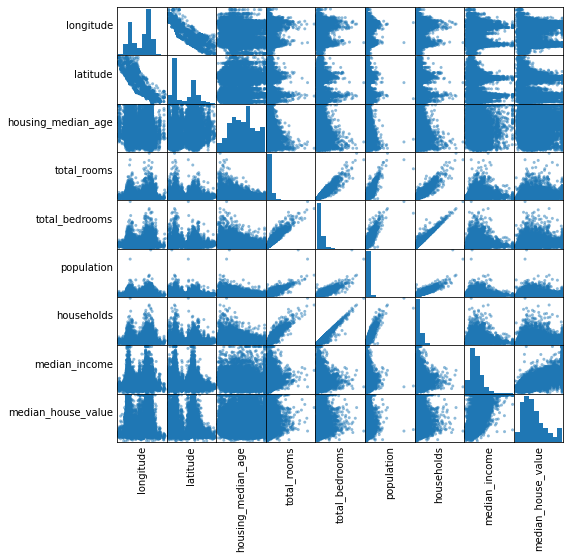

In [0]:
#To visualize coorelations
from pandas.plotting import scatter_matrix

numeric_data = df.select(df.columns).toPandas()

axs = scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(df.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [0]:
# from pyspark.ml.linalg import Vectors
# from pyspark.ml.feature import VectorAssembler
# assembler=VectorAssembler(inputCols=["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income"],outputCol="Features")
# output=assembler.transform(df)
# output.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|            Features|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|[-114.31,34.19,15...|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|[-114.47,34.4,19....|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|[-114.56,33.69,17...|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|[-114.57,33.64,14...|

In [0]:
# assembler=VectorAssembler(inputCols=["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income"],outputCol="Features")

In [0]:
# output=assembler.transform(df)


In [0]:
# output.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|            Features|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|[-114.31,34.19,15...|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|[-114.47,34.4,19....|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|[-114.56,33.69,17...|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|[-114.57,33.64,14...|

In [0]:
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+



In [0]:
#Normalization
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())


# Iterating over columns to be scaled
for i in ["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df = pipeline.fit(df).transform(df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")


In [0]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+----------------+---------------+-------------------------+------------------+---------------------+-----------------+-----------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|longitude_Scaled|latitude_Scaled|housing_median_age_Scaled|total_rooms_Scaled|total_bedrooms_Scaled|population_Scaled|households_Scaled|median_income_Scaled|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+----------------+---------------+-------------------------+------------------+---------------------+-----------------+-----------------+--------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|             1.0|          0.175|         

In [0]:
df=df.drop("longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income")

In [0]:
df.show(2)

+------------------+----------------+---------------+-------------------------+------------------+---------------------+-----------------+-----------------+--------------------+
|median_house_value|longitude_Scaled|latitude_Scaled|housing_median_age_Scaled|total_rooms_Scaled|total_bedrooms_Scaled|population_Scaled|households_Scaled|median_income_Scaled|
+------------------+----------------+---------------+-------------------------+------------------+---------------------+-----------------+-----------------+--------------------+
|           66900.0|             1.0|          0.175|                    0.275|             0.148|                0.199|            0.028|            0.077|               0.069|
|           80100.0|           0.984|          0.198|                    0.353|             0.202|                0.295|            0.032|            0.076|               0.091|
+------------------+----------------+---------------+-------------------------+------------------+------------

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
assembler=VectorAssembler(inputCols=["longitude_Scaled","latitude_Scaled","housing_median_age_Scaled","total_rooms_Scaled","total_bedrooms_Scaled","population_Scaled","households_Scaled","median_income_Scaled"],outputCol="Features")
output=assembler.transform(df)
output.show(5)

+------------------+----------------+---------------+-------------------------+------------------+---------------------+-----------------+-----------------+--------------------+--------------------+
|median_house_value|longitude_Scaled|latitude_Scaled|housing_median_age_Scaled|total_rooms_Scaled|total_bedrooms_Scaled|population_Scaled|households_Scaled|median_income_Scaled|            Features|
+------------------+----------------+---------------+-------------------------+------------------+---------------------+-----------------+-----------------+--------------------+--------------------+
|           66900.0|             1.0|          0.175|                    0.275|             0.148|                0.199|            0.028|            0.077|               0.069|[1.0,0.175,0.275,...|
|           80100.0|           0.984|          0.198|                    0.353|             0.202|                0.295|            0.032|            0.076|               0.091|[0.984,0.198,0.35...|
|    

In [0]:
final_data=output.select("Features","median_house_value")


In [0]:
final_data.show(4)

+--------------------+------------------+
|            Features|median_house_value|
+--------------------+------------------+
|[1.0,0.175,0.275,...|           66900.0|
|[0.984,0.198,0.35...|           80100.0|
|[0.975,0.122,0.31...|           85700.0|
|[0.974,0.117,0.25...|           73400.0|
+--------------------+------------------+
only showing top 4 rows



In [0]:
train_data,test_data=final_data.randomSplit([0.75,0.25])


In [0]:
from pyspark.ml.regression import LinearRegression

# regressor=LinearRegression(featuresCol='Features', labelCol='median_house_value')
# regressor=regressor.fit(train_data)
# from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'Features', labelCol='median_house_value', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-409156.4629832559,-386713.4785766636,68607.701973807,-170743.4262489216,534917.079674694,-1662914.8003124746,544565.5999369442,571093.2480927599]
Intercept: 347715.3903216149


In [0]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 69632.105872
r2: 0.635874


In [0]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction","median_house_value","Features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="median_house_value",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------------------+--------------------+
|        prediction|median_house_value|            Features|
+------------------+------------------+--------------------+
|188540.11462043168|           94600.0|[0.0,0.85,1.0,0.0...|
|155783.01650007133|           79000.0|[0.008,0.866,0.68...|
|169859.76390603586|          111400.0|[0.009,0.854,1.0,...|
|109682.30538385146|           58100.0|[0.014,0.872,0.60...|
| 51860.22748605278|           74600.0|[0.016,0.982,0.27...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.649849


In [0]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'Features', labelCol = 'median_house_value', maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'median_house_value', 'Features').show(5)

+------------------+------------------+--------------------+
|        prediction|median_house_value|            Features|
+------------------+------------------+--------------------+
|126574.05200261771|           94600.0|[0.0,0.85,1.0,0.0...|
| 83615.33672773745|           79000.0|[0.008,0.866,0.68...|
|127959.02831294462|          111400.0|[0.009,0.854,1.0,...|
| 89666.11629366632|           58100.0|[0.014,0.872,0.60...|
|   95164.297611219|           74600.0|[0.016,0.982,0.27...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [0]:
gbt_evaluator = RegressionEvaluator(
    labelCol="median_house_value", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 0.720579
